Geometry: NDBR50, Epoch [100/5000], Loss: 151490.5469
Geometry: NDBR50, Epoch [200/5000], Loss: 151447.6094
Geometry: NDBR50, Epoch [300/5000], Loss: 151397.2188
Geometry: NDBR50, Epoch [400/5000], Loss: 151398.4531
Geometry: NDBR50, Epoch [500/5000], Loss: 151120.8750
Geometry: NDBR50, Epoch [600/5000], Loss: 154087.4688
Geometry: NDBR50, Epoch [700/5000], Loss: 148468.3281
Geometry: NDBR50, Epoch [800/5000], Loss: 147889.8125
Geometry: NDBR50, Epoch [900/5000], Loss: 147833.0625
Geometry: NDBR50, Epoch [1000/5000], Loss: 147786.4219
Geometry: NDBR50, Epoch [1100/5000], Loss: 147736.2656
Geometry: NDBR50, Epoch [1200/5000], Loss: 147681.4844
Geometry: NDBR50, Epoch [1300/5000], Loss: 147620.7812
Geometry: NDBR50, Epoch [1400/5000], Loss: 147552.3594
Geometry: NDBR50, Epoch [1500/5000], Loss: 147474.0312
Geometry: NDBR50, Epoch [1600/5000], Loss: 147380.8125
Geometry: NDBR50, Epoch [1700/5000], Loss: 147266.7969
Geometry: NDBR50, Epoch [1800/5000], Loss: 147056.9531
Geometry: NDBR50, E

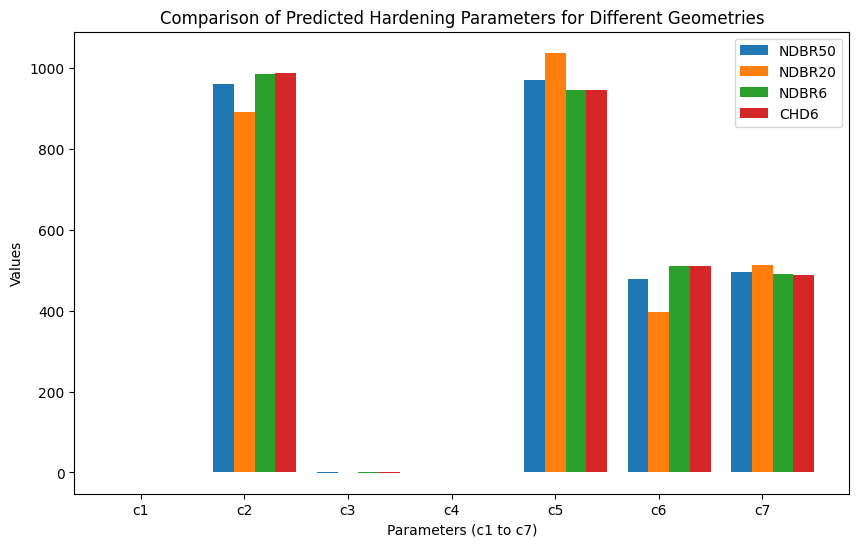

In [2]:
################################
##                            ##
##      leaky relu            ##
##                            ##
################################


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F


# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
dataPoints = {'NDBR50': 20200, 'NDBR20': 20200, 'NDBR6': 20200, 'CHD6': 20200}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/NEWDATA/newData_NDBR50_FD.csv",
    'NDBR20': "MODEL_DATA/NEWDATA/newData_NDBR20_FD.csv",
    'NDBR6': "MODEL_DATA/NEWDATA/newData_NDBR6_FD.csv",
    'CHD6': "MODEL_DATA/NEWDATA/newData_CHD6_FD.csv"
}

Y_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

# Define a custom neural network model with regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.LeakyReLU(negative_slope=0.01)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu_out = nn.ReLU()  #

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu1(x)
        x = self.fc2(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu2(x)
        x = self.fc3(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu3(x)
        x = self.fc4(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu4(x)
        x = self.fc5(x)
        return x


# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        reg_loss = torch.mean((outputs - target_values) ** 2)
        return mse_loss + self.lambda_reg * reg_loss

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 64  # Number of units in the first hidden layer
hidden_size2 = 64  # Number of units in the second hidden layer
hidden_size3 = 64  # Number of units in the second hidden layer
hidden_size4 = 64  # Number of units in the second hidden layer
output_size = 7    # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)


# Define a loss function (custom MSE loss with regularization) and an optimizer (e.g., Adam)
criterion = CustomMSELoss(lambda_reg=0.01)  # Adjust lambda_reg as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5000

target_values = torch.tensor([ 0.5, 1300, 2.3 * 10**-14, 0.075, 773.18, 1039.37, 73.94], 
                             dtype=torch.float32)

for geometry in geometries:
    num_samples = min(dataPoints[geometry], len(Y_data))
    X_sample = torch.tensor(X_data[geometry][:num_samples], dtype=torch.float32)
    Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss with regularization
        loss = criterion(outputs, Y_sample, target_values)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)

plt.legend()
plt.show()